## **Semi-structured RAG**

Many documents, such as PDFs, contain a mix of content types, including text and tables. Working with semi-structured data in RAG workflows can be challenging for two key reasons:

1. **Text Splitting Issues**: Splitting text may inadvertently break tables, leading to corrupted data during retrieval.
2. **Embedding Challenges**: Tables often pose difficulties for embedding models, as they are not inherently suited for semantic similarity searches.

This guide demonstrates a robust approach to performing RAG on documents with semi-structured data:

- **Parsing Mixed Content**: We'll leverage the *Unstructured* library to extract both text and tables from documents.
- **Efficient Storage and Retrieval**: Using a multi-vector retriever, we will store raw tables, text, and table summaries, ensuring a retrieval process optimized for both content types.

By addressing these challenges, this method enhances the accuracy and usability of RAG systems when working with semi-structured data.

---

This version maintains a professional tone, uses concise language, and aligns with the purpose of providing a clear and actionable guide for contributors.



Reference: [Semi Structured RAG](https://blog.langchain.dev/semi-structured-multi-modal-rag/)


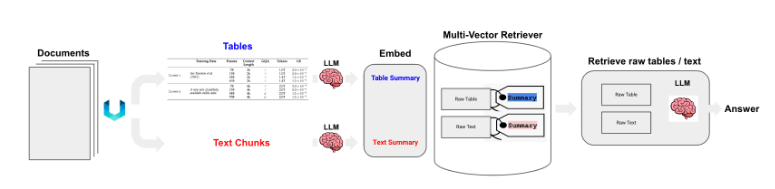

## **Initial Setup**

In [ ]:
! pip install langchain "unstructured[all-docs]" pydantic lxml langchainhub langchain-community chromadb datasets -q
!apt-get update -q
!apt-get install -y poppler-utils tesseract-ocr -q
!pip install groq langchain_groq -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://r2u.stat.illinois.edu/u

In [ ]:
import uuid
import os
import openai
from typing import Any
from pydantic import BaseModel
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.documents import Document
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceBgeEmbeddings
from unstructured.partition.pdf import partition_pdf
from groq import Groq
from langchain_groq import ChatGroq


import os
from google.colab import userdata
os.environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY')
os.environ['ATHINA_API_KEY'] = userdata.get('ATHINA_API_KEY')

## **Extracting the Data**

The PDF partitioning used by Unstructured will use:



*   tesseract for Optical Character Recognition (OCR)
*   poppler for PDF rendering and processing




In [ ]:
# Extract elements from the PDF
raw_pdf_elements = partition_pdf(
    filename="/content/llama.pdf",                 # Path to the PDF file
    extract_images_in_pdf=False,                  # Disable image extraction from PDF
    infer_table_structure=True,                   # Enable table structure inference using a layout model
    chunking_strategy="by_title",                 # Aggregate text based on document titles
    max_characters=4000,                          # Maximum characters per chunk
    new_after_n_chars=3800,                       # Attempt to create a new chunk after 3800 characters
    combine_text_under_n_chars=2000,              # Combine text blocks smaller than 2000 characters
    image_output_dir_path='/content/Image_Output' # Directory for storing extracted images
)


In [ ]:
raw_pdf_elements

In [ ]:
# Create a dictionary to store counts of each type
category_counts = {}

for element in raw_pdf_elements:
    category = str(type(element))
    if category in category_counts:
        category_counts[category] += 1
    else:
        category_counts[category] = 1

# Unique_categories will have unique elements
unique_categories = set(category_counts.keys())
category_counts

{"<class 'unstructured.documents.elements.CompositeElement'>": 5,
 "<class 'unstructured.documents.elements.Table'>": 2}

In [ ]:
class Element(BaseModel):
    type: str
    text: Any


# Categorize by type
categorized_elements = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        categorized_elements.append(Element(type="table", text=str(element)))
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        categorized_elements.append(Element(type="text", text=str(element)))

# Tables
table_elements = [e for e in categorized_elements if e.type == "table"]
print(len(table_elements))

# Text
text_elements = [e for e in categorized_elements if e.type == "text"]
print(len(text_elements))

2
5


In [ ]:
table_elements

[Element(type='table', text='Finetuned Multilingual Long context Tool use Release Llama 3 8B ✗ ✗1 ✗ ✗ April 2024 Llama 3 8B Instruct ✓ ✗ ✗ ✗ April 2024 Llama 3 70B ✗ ✗1 ✗ ✗ April 2024 Llama 3 70B Instruct ✓ ✗ ✗ ✗ April 2024 Llama 3.1 8B ✗ ✓ ✓ ✗ July 2024 Llama 3.1 8B Instruct ✓ ✓ ✓ ✓ July 2024 Llama 3.1 70B ✗ ✓ ✓ ✗ July 2024 Llama 3.1 70B Instruct ✓ ✓ ✓ ✓ July 2024 Llama 3.1 405B ✗ ✓ ✓ ✗ July 2024 Llama 3.1 405B Instruct ✓ ✓ ✓ ✓ July 2024'),
 Element(type='table', text='B 0 Category Benchmark B 8 3 a m a l L B 9 2 a m m e G B 7 l a r t s i M B 0 7 3 a m a l L B 2 2 x 8 l a r t x i M o b r u T 5 . 3 T P G B 5 0 4 3 a m a l L 4 3 4 n o r t o m e N ) 5 2 1 0 ( 4 - T P G o 4 - T P G MMLU (5-shot) 69.4 72.3 61.1 83.6 76.9 70.7 87.3 82.6 85.1 89.1 General MMLU (0-shot, CoT) MMLU-Pro (5-shot, CoT) 73.0 48.3 72.3△ 60.5 – 36.9 86.0 79.9 66.4 56.3 69.8 49.2 88.6 73.3 78.7◁ 62.7 85.4 64.8 88.7 74.0 IFEval 80.4 73.6 57.6 87.5 72.7 69.9 88.6 85.1 84.3 85.6 Code HumanEval (0-shot) MBPP EvalPlus (0-s

## **Summarizing the Data**

In [ ]:
# Prompt
prompt_text = """You are an assistant tasked with summarizing tables and text. \
Give a detailed summary of the table or text. Table or text chunk: {element} """
prompt = ChatPromptTemplate.from_template(prompt_text)

model = ChatGroq(groq_api_key = os.getenv('GROQ_API_KEY'), model = 'llama-3.2-90b-vision-preview')
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

In [ ]:
# Apply to tables
tables = [i.text for i in table_elements]
table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

In [ ]:
# Apply to texts
texts = [i.text for i in text_elements]
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})

## **Storing the Data**

In [ ]:
import chromadb
from chromadb.api.fastapi import FastAPI
from langchain.embeddings import HuggingFaceBgeEmbeddings
from langchain.vectorstores import Chroma
from langchain.retrievers import MultiVectorRetriever
from langchain.docstore.document import Document
from langchain.storage import InMemoryStore
import uuid

# Model configuration
model_name = "BAAI/bge-small-en-v1.5"
encode_kwargs = {'normalize_embeddings': True}  # Normalize embeddings for cosine similarity

# Initialize HuggingFace embeddings
bge_embeddings = HuggingFaceBgeEmbeddings(
    model_name=model_name,
    model_kwargs={'device': 'cpu'},
    encode_kwargs=encode_kwargs
)

# Initialize ChromaDB client and vector store
client = chromadb.Client()  # Use default client
vectorstore = Chroma(
    collection_name="summaries",
    embedding_function=bge_embeddings,
    client=client
)

# Initialize in-memory storage and retriever
store = InMemoryStore()
id_key = "doc_id"

retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

# Generate unique IDs for document texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=text, metadata={id_key: doc_ids[i]})
    for i, text in enumerate(text_summaries)
]

# Add document summaries to retriever
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

# Generate unique IDs for table data
table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [
    Document(page_content=table, metadata={id_key: table_ids[i]})
    for i, table in enumerate(table_summaries)
]

# Add table summaries to retriever
retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tables)))

## **RAG Chain**

In [ ]:

# Prompt template
template = """Answer the question based only on the following context, which can include text and tables:
{context}
Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

# LLM
model = ChatGroq(groq_api_key = os.getenv('GROQ_API_KEY'), model = 'llama-3.1-70b-versatile')

# RAG pipeline
chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

In [ ]:
chain.invoke("What is the number of training tokens for LLaMA3?")

'According to the provided text, the LLaMA 3 language model was pre-trained on 15.6 trillion (15.6T) tokens.'

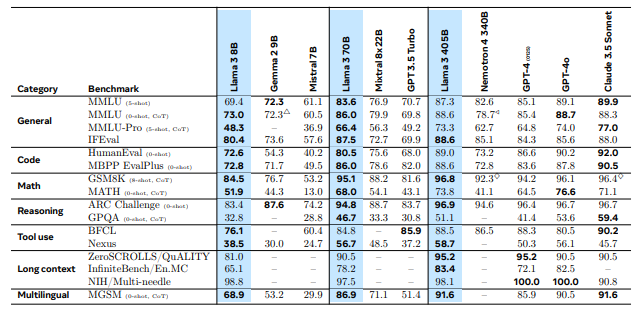

In [ ]:
chain.invoke("which model has the highest score in Math category")

'According to the table, in the Math category, GSM8K (8-shot, CoT) has the highest score of 96.8 for the MATH (0-shot, CoT) model.'

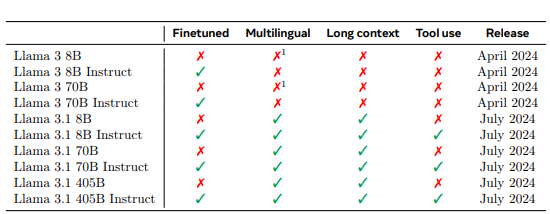

In [ ]:
chain.invoke("Release date of 405B Instruct model")

'The release date of the Llama 3.1 405B Instruct model is July 2024.'

## **Preparing Data for Evaluation**

In [ ]:
# create dataset
questions = ["Release date of 405B Instruct model"]
response = []
contexts = []

# Inference
for query in questions:
  response.append(chain.invoke(query))
  contexts.append([docs for docs in retriever.get_relevant_documents(query)])

# To dict
data = {
    "query": questions,
    "response": response,
    "context": contexts,
}


<ipython-input-32-400711ab00ad>:9: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  contexts.append([docs for docs in retriever.get_relevant_documents(query)])


In [ ]:
# create dataset
from datasets import Dataset
dataset = Dataset.from_dict(data)

In [ ]:
# create dataframe
import pandas as pd
df = pd.DataFrame(dataset)

In [ ]:
df

,query,response,context
0,Release date of 405B Instruct model,The release date of the Llama 3.1 405B Instruc...,[Finetuned Multilingual Long context Tool use ...


In [ ]:

# Convert to dictionary
df_dict = df.to_dict(orient='records')

# Convert context to list
for record in df_dict:
    if not isinstance(record.get('context'), list):
        if record.get('context') is None:
            record['context'] = []
        else:
            record['context'] = [record['context']]

In [ ]:
# set api keys for Athina evals
from athina.keys import AthinaApiKey, OpenAiApiKey
OpenAiApiKey.set_key(os.getenv('OPENAI_API_KEY'))
AthinaApiKey.set_key(os.getenv('ATHINA_API_KEY'))

In [ ]:
# load dataset
from athina.loaders import Loader
dataset = Loader().load_dict(df_dict)

In [ ]:
# evaluate
from athina.evals import RagasContextRelevancy
RagasContextRelevancy(model="gpt-4o").run_batch(data=dataset).to_df()